# DEAP Short Tutorial

**DEAP** (Distributed Evolutionary Algorithms for Python) is a Python module which provides you with tools to easily implement evolutionary computation algorithms.

In this short tutorial you'll learn how to set up everything to start working with it right away.

First off, install and import as you would do with any Python module.

In [1]:
from deap import base, creator, tools  # deap utilities
import random
import numpy as np  # numerical computation
import matplotlib.pyplot as plt   # plotting

Now we start by setting information about the problem:

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

I'm _creating_ two classes here:
- An `Individual` which inherits the `list` type, with an attribute named `fitness` which is another object:
    - A `FitnessMin` class which inherits `base.Fitness`, with an atribute named `weights` initialized at `(-1.0,)`
   
Minimisation and maximisation are pretty similar in optimisation: you usually flip the symbol $<$ for $>$ which is setting the weight to -1 or 1.

Now let's add some more info about the algorithm:

In [3]:
IND_SIZE = 10  # chromosome length

toolbox = base.Toolbox()
toolbox.register("attribute", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list,toolbox.individual)

First we instantiate a `Toolbox` and `register` _methods_ in it.

For example, we are registering the `attribute` method which is just calling `random.random`. It is generating an attribute (a gene), which in this case is a random float between 0 and 1.

The `tools.initRepeat` method is tricky. Taking a look at its documentation shows that it repeats a _method_ $n$ times, and fills a _container_ with it. On line 5, we are repeating `toolbox.attribute` `IND_SIZE` times, and filling the `creator.Individual` container. This process is registered now as `toolbox.individual`.

We now add the objective function and operators:

In [4]:
def evaluate(ind):
    """ Returns the fitness of an individual.
    This is your objective function."""
    return sum(ind),  #  must return a tuple

# Operators
toolbox.register("cross", tools.cxTwoPoint)  
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1) 
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

We now registered some of the operators dealing with the individuals.
As you can see, `tools.cxTwoPoint` is a two-point crossover. It receives two individuals and modify them **inplace**. A tuple is returned containing a view of two individuals.

The `tools.mutGaussian`, as you can guess, is the distribution of the mutation. This needs real-valued individuals of course.

Notice how on line 4 we return a tuple in the `evaluate` function, as fitness values must be iterables in order for multi-objective optimisation to be included in the schematics of the library.
Single objective optimisation is a special case of multi-objective: using 1-tuple.

## Putting things together

This is the whole algorithm implemented using the tools we defined. It is a generational Genetic Algorithm—each generation will replace the previous one.

In [5]:
def generationalGA():
    pop = toolbox.population(n=50)  # Registered as a list
    CXPB = 0.5  # Crossover probability
    MUTPB = 0.2  # Mutation probability
    NGEN = 40 # Number of generations
    
    # Evaluate all population first
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    # Generate offspring
    for __ in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))  # Generate a deep copy
        
        # Apply crossover
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.cross(c1, c2)
                # Reset their fitness values
                del c1.fitness.values
                del c2.fitness.values

        # Mutate those selected
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                # Reset fitness values
                del mutant.fitness.values

        # Evaluate non-evaluated individuals in offspring
        invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_inds)
        for ind, fit in zip(invalid_inds, fitnesses):
            ind.fitness.values = fit

        # Replace entire population by the offspring
        pop[:] = offspring
    
    return pop

Since we are getting a list as the return value, we can access each individual or its features accordingly:

In [6]:
results = generationalGA()
fitnesses = [i.fitness.getValues()[0] for i in results]

bestpos = fitnesses.index(min(fitnesses))
print("Individual: {0}\n\nFitness: {1}".format(
        results[bestpos], results[bestpos].fitness.getValues()[0]))

Individual: [0.007255964641715962, -3.7128774659861112, -2.3940455890783134, -8.190571991822432, -0.8942735610322432, -8.585607468392073, -2.753605093491699, -2.015675322782945, -4.444005821030648, -5.351258705602769]

Fitness: -38.33466505457752


---

## 1 + 1 EA using NumPy arrays

As you probably noticed, we used plain old lists as the individual and population containers. We can use `numpy` arrays if you're used to that, too. Let's give it a go with the OneMax problem.

First problem information:

In [7]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("IndividualNP", np.ndarray, fitness=creator.FitnessMax)

The OneMax problem looks to maximise the number of ones in a chromosome, so this time we're choosing from random integers between 0 and 1.
The rest is pretty similar.

In [8]:
IND_LENGTH = 20

toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.IndividualNP,
                 toolbox.attribute, n=IND_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

- **Objective function**: In case of the OneMax problem, we want to maximise the number of 1s so the sum of an individual represents its fitness.
- **Mutation**: we can flip the bits, so we use `UniformInt` between 0 and 1. Each bit has $1/n$ probability of changing.

In [9]:
def evaluate_ind(a):
    return a.sum(), # return a tuple

toolbox.register("mutate", tools.mutUniformInt, low=0, up=1,
                 indpb=1.0 / IND_LENGTH)
toolbox.register("evaluate", evaluate_ind)

We're gonna introduce a couple of useful tools now:

- **Hall of Fame**: Remember the best individual and its fitness over the entire timespan.
- **Logbook**: Record statistics of your algorithm to review later.

In [10]:
#  Instantiate HoF and Logbook
hof = tools.HallOfFame(1, similar=np.array_equal)  # Notice the np.array_equal
log = tools.Logbook()


def oneplusone():
    # We don't really need a container, but let's
    # stick to the original metaphor of evolution
    pop = toolbox.population(n=1)
    
    NGEN = 25  # Number of generations
    
    for gen in range(NGEN):
        parent = pop[0]  # This is just an alias
        # Evaluate everyone (i.e. one individual)
        ind_fitness = list(map(toolbox.evaluate, pop))
        # ...and set its fitness
        parent.fitness.values = ind_fitness[0]

        # Clone
        child = toolbox.clone(parent)
        
        # Always mutate
        toolbox.mutate(child)
        # ...and reset its fitness after mutation
        del child.fitness.values

        # Reevaluate the child
        child.fitness.values = toolbox.evaluate(child)

        # Compare & keep best
        if child.fitness >= parent.fitness:
            pop[:] = [child]
            hof.update(pop)
        # Record statistics
        log.record(agen=gen, ind=pop[0], fit=pop[0].fitness.getValues()[0])
    
    return pop

In [11]:
results = oneplusone()
print("Individual: {0}\n\nFitness: {1}".format(
        results[0], results[0].fitness.getValues()[0]))

Individual: [1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]

Fitness: 12.0


We can `select` specific statistics from the logbook, or pretty-print them all at once:

In [12]:
print(log)

agen	fit 	ind                                      
0   	9.0 	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1]
1   	9.0 	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1]
2   	9.0 	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1]
3   	9.0 	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1]
4   	9.0 	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1]
5   	9.0 	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1]
6   	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
7   	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
8   	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
9   	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
10  	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
11  	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
12  	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
13  	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
14  	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
15  	10.0	[1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1]
16  	11.0	[1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]
17  	11.0	[1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]
18  	11.0	[1

The statistics are already lists of values:

In [13]:
type(log.select("agen"))

list

So we're able to easily plot them with `pyplot`:

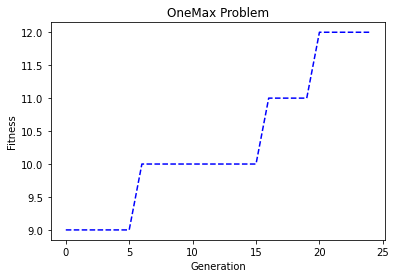

In [14]:
gen = log.select("agen")
fit = log.select("fit")

fig, ax = plt.subplots()
line = ax.plot(gen, fit, "b--", label="Maximum Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
plt.title("OneMax Problem")
plt.show()